#Dataloading 

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
%matplotlib inline

In [ ]:
od.download('https://www.kaggle.com/paultimothymooney/blood-cells')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: maniyarsuyash
Your Kaggle Key: ··········


100%|██████████| 108M/108M [00:03<00:00, 37.4MB/s]


In [ ]:
%cd blood-cells

/content/blood-cells


In [ ]:
%cd dataset2-master/dataset2-master/images

/content/blood-cells/dataset2-master/dataset2-master/images


In [ ]:
DATA_DIR = '/content/blood-cells/dataset2-master/dataset2-master'


TRAIN_DIR = DATA_DIR + '/images/TRAIN'                           # Contains training images
TEST_DIR = DATA_DIR + '/images/TEST'                             # Contains test images

LABELS_CSV = DATA_DIR + '/labels.csv'                       # Contains real labels for training images

In [ ]:
%cd ..

/content/blood-cells/dataset2-master/dataset2-master


In [ ]:
df = pd.read_csv("labels.csv") 

In [ ]:
df

,Unnamed: 0,Image,Category
0,NaN,0,NEUTROPHIL
1,NaN,1,NEUTROPHIL
2,NaN,2,NEUTROPHIL
3,NaN,3,NEUTROPHIL
4,NaN,4,NEUTROPHIL
...,...,...,...
406,NaN,406,NaN
407,NaN,407,NEUTROPHIL
408,NaN,408,NEUTROPHIL
409,NaN,409,NEUTROPHIL


In [ ]:
all_eosinophils=os.listdir(TRAIN_DIR + "/EOSINOPHIL")
len(all_eosinophils)

2497

In [ ]:
all_eosinophils=os.listdir(TRAIN_DIR + "/EOSINOPHIL")
len(all_eosinophils)

2497

In [ ]:
PROCESSED_DATA_DIR = '/content/blood-cells'
PROCESSED_TRAIN_DIR = PROCESSED_DATA_DIR + '/train'
PROCESSED_TEST_DIR = PROCESSED_DATA_DIR + '/test'
TRAIN_CSV = PROCESSED_DATA_DIR + '/train_labels.csv'
TEST_CSV = PROCESSED_DATA_DIR + '/test_labels.csv'

In [ ]:
def get_labels(folder_path, filename_to_save=None):
  ''' Gets folder path and returns labels dataframe '''
  labels = np.column_stack(([],[],[]))
  dirnames = os.listdir(folder_path)
  for i, dirname in enumerate(dirnames):
    if os.path.isdir(os.path.join(folder_path, dirname)):
      files_list = os.listdir(os.path.join(folder_path, dirname))      
      labels = np.vstack((labels, np.column_stack((([dirname] * len(files_list)),([i] * len(files_list)), files_list))))
  labels_df = pd.DataFrame(labels, columns = ['text_label', 'num_label', 'img_name'])
  if filename_to_save:
    labels_df.to_csv(filename_to_save)
  return labels_df

In [ ]:
train_labels = get_labels(TRAIN_DIR, TRAIN_CSV)

In [ ]:
test_labels = get_labels(TEST_DIR, TEST_CSV)

In [ ]:
lab_test = pd.DataFrame(test_labels.groupby(['text_label', 'num_label']).count())
lab_test

,,img_name
text_label,num_label,
EOSINOPHIL,2,623
LYMPHOCYTE,0,620
MONOCYTE,3,620
NEUTROPHIL,1,624


In [ ]:
lab = pd.DataFrame(train_labels.groupby(['text_label', 'num_label']).count())
lab

,,img_name
text_label,num_label,
EOSINOPHIL,2,2497
LYMPHOCYTE,0,2483
MONOCYTE,3,2478
NEUTROPHIL,1,2499


In [ ]:
labels_dict = {
    0: 'MONOCYTE',
    1: 'EOSINOPHIL',
    2: 'LYMPHOCYTE',
    3: 'NEUTROPHIL',    
}

In [ ]:
import shutil

def move_files(folder_path, folder):
  if not os.path.exists(folder):
    os.makedirs(folder)
  dirnames = os.listdir(folder_path)
  for i, dirname in enumerate(dirnames):
    if os.path.isdir(os.path.join(folder_path, dirname)):
      files_list = os.listdir(os.path.join(folder_path, dirname))
      for item in files_list:
          shutil.move(os.path.join(folder_path, dirname, item), os.path.join(folder, item))
  print(len(os.listdir(folder)), 'files moved.')

In [ ]:
move_files(TRAIN_DIR, PROCESSED_TRAIN_DIR)


9893 files moved.


In [ ]:
duplicated_img_name = list(train_labels[train_labels.img_name.duplicated()]['img_name'])

In [ ]:
removed_df = train_labels[train_labels.img_name.isin(duplicated_img_name)]

In [ ]:
def clean_data(img_dir, df, df_csv, removed_img_dir, removed_file):
  if not os.path.exists(removed_img_dir):
    os.makedirs(removed_img_dir)
  duplicated_img_list = list(df[df.img_name.duplicated()]['img_name'])
  removed_df = df[df.img_name.isin(duplicated_img_list)]
  removed_df.to_csv(removed_file)
  print(removed_df.shape[0], 'ambigous items moved to', removed_file)
  df.drop(index = df.index[df.img_name.isin(duplicated_img_list)], axis = 0, inplace = True)
  df.to_csv(df_csv)
  print('Now shape of dataframe', df.shape)
  
  files_list = os.listdir(img_dir)
  for item in files_list:
    if item in duplicated_img_list:
      shutil.move(os.path.join(img_dir, item), os.path.join(removed_img_dir, item))
  print(len(os.listdir(removed_img_dir)), 'moved to', removed_img_dir)

In [ ]:
clean_data(PROCESSED_TRAIN_DIR, train_labels, TRAIN_CSV, PROCESSED_DATA_DIR + '/removed_train', PROCESSED_DATA_DIR + '/removed_train.csv')

128 ambigous items moved to /content/blood-cells/removed_train.csv
Now shape of dataframe (9829, 3)
64 moved to /content/blood-cells/removed_train


In [ ]:
assert(len(os.listdir(PROCESSED_TRAIN_DIR)) == train_labels.shape[0])

In [ ]:
move_files(TEST_DIR, PROCESSED_TEST_DIR)

2476 files moved.


In [ ]:
duplicated_test_img_name = test_labels[test_labels.img_name.duplicated()]['img_name']


In [ ]:
clean_data(PROCESSED_TEST_DIR, test_labels, TEST_CSV, PROCESSED_DATA_DIR + '/removed_test', PROCESSED_DATA_DIR + '/removed_test.csv')

22 ambigous items moved to /content/blood-cells/removed_test.csv
Now shape of dataframe (2465, 3)
11 moved to /content/blood-cells/removed_test


In [ ]:
assert(len(os.listdir(PROCESSED_TEST_DIR)) == test_labels.shape[0])

In [ ]:
def encode_label(label):
    target = torch.zeros(4)
    target[int(label)] = 1.
    return target

def decode_target(target, text_labels=False):
    result = []
    i = np.argmax(target.numpy())
    if text_labels:
        result.append(labels_dict[i] + "(" + str(i) + ")")
    else:
        result.append(str(i))
    return ' '.join(result)

In [ ]:
class HumanBloodCellDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_name, img_label = row['img_name'], row['num_label']
        img_fname = self.root_dir + "/" + str(img_name)
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, encode_label(img_label) 

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = HumanBloodCellDataset(TRAIN_CSV, PROCESSED_TRAIN_DIR, transform=transform)

In [ ]:
#dataset = HumanBloodCellDataset(TRAIN_CSV, PROCESSED_TRAIN_DIR, transform=transform)

In [ ]:
class HumanBloodCellDataset2(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_name, img_label = row['img_name'], row['num_label']
        img_fname = self.root_dir + "/" + str(img_name)
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img,int(img_label)

In [ ]:
dataset2 = HumanBloodCellDataset2(TRAIN_CSV, PROCESSED_TRAIN_DIR, transform=transform)

In [ ]:
def show_sample(img, target, invert=False):
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print('Labels:', decode_target(target, text_labels=True))

Labels: MONOCYTE(0)


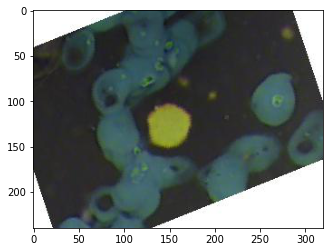

In [ ]:
show_sample(*dataset[0], invert=True)

Labels: MONOCYTE(0)


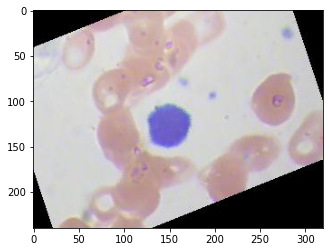

In [ ]:
show_sample(*dataset[0], invert=False)

Labels: EOSINOPHIL(1)


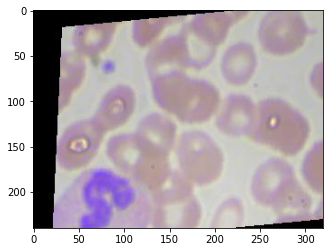

In [ ]:
show_sample(*dataset[3000], invert=False)

Labels: LYMPHOCYTE(2)


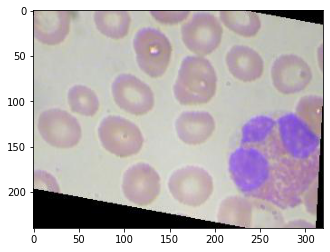

In [ ]:
show_sample(*dataset[6000], invert=False)

Labels: NEUTROPHIL(3)


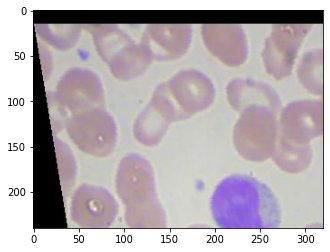

In [ ]:
show_sample(*dataset[9000], invert=False)

In [ ]:
torch.manual_seed(10)

In [ ]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

In [ ]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(8847, 982)

In [ ]:
train_ds2, val_ds2 = random_split(dataset2, [train_size, val_size])
len(train_ds2), len(val_ds2)

(8847, 982)

In [ ]:
batch_size = 64

In [ ]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import random
from torch import nn
from sklearn import svm
train_on_gpu = torch.cuda.is_available()
!pip install torchinfo -q
import torchvision.models as models
from torchinfo import summary
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn import svm
import matplotlib.pyplot as plt

#VGG

In [ ]:
config = {
    'batch_size':64,
    'test_size':0.2,
    'num_workers' : 2, 
    'pin_memory' : True,
    'learning_rate' : 0.001,
    'n_epochs' : 5,
    'test_batch_size': 64
}

In [ ]:
train_dataloader = DataLoader(
    train_ds2, batch_size=config['batch_size'], shuffle = True, 
    pin_memory = config['pin_memory'], num_workers = config['num_workers']
  )

test_dataloader = DataLoader(
    val_ds2, batch_size=config['batch_size'], shuffle = True, 
    pin_memory = config['pin_memory'], num_workers = config['num_workers']
  )

In [ ]:
vgg = models.vgg16(pretrained=True)
num_ftrs=vgg.classifier[0].in_features
vgg.fc=nn.Linear(num_ftrs,4)

if train_on_gpu:
  vgg.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg.parameters(),lr=config['learning_rate'])

summary(vgg,input_size=(1,3,240,320))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      --                        --
├─Sequential: 1-1                        [1, 512, 7, 10]           --
│    └─Conv2d: 2-1                       [1, 64, 240, 320]         1,792
│    └─ReLU: 2-2                         [1, 64, 240, 320]         --
│    └─Conv2d: 2-3                       [1, 64, 240, 320]         36,928
│    └─ReLU: 2-4                         [1, 64, 240, 320]         --
│    └─MaxPool2d: 2-5                    [1, 64, 120, 160]         --
│    └─Conv2d: 2-6                       [1, 128, 120, 160]        73,856
│    └─ReLU: 2-7                         [1, 128, 120, 160]        --
│    └─Conv2d: 2-8                       [1, 128, 120, 160]        147,584
│    └─ReLU: 2-9                         [1, 128, 120, 160]        --
│    └─MaxPool2d: 2-10                   [1, 128, 60, 80]          --
│    └─Conv2d: 2-11                      [1, 256, 60, 80]          29

In [ ]:
def train_model(model ,train_dataloader,test_dataloader, training_name, optimizer,criterion,config=config):


  train_losses = []
  test_losses = []
  train_acc = []
  test_acc = []
  min_loss = float('inf')
  n_epochs = config['n_epochs']
  for epoch in (range(n_epochs)):
    training_loss = 0.0
    train_c = 0
    testing_loss = 0.0
    test_c = 0

    model.train()
    for data in train_dataloader:

      images,labels = data
      images = images.cuda()
      labels = labels.cuda() 
      outputs = model(images)
      loss = criterion(outputs,labels)  
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      _, predicted = torch.max(outputs, 1)
      train_c += torch.sum(predicted==labels).item()

      training_loss += loss.item()
    print(f'Training accuracy in epoch  {epoch+1}  : {(train_c/len(train_dataloader.dataset))*100:.3f}')
    print(f'Train Loss in epoch {epoch+1}  : {(training_loss/len(train_dataloader)):.3f}')
    print('-'*80)
    print('-'*80)
 
    model.eval()
    with torch.no_grad():
      for data in test_dataloader:
        images,labels = data
        images = images.cuda()
        labels = labels.cuda()
        # Forward Pass 
        outputs = model(images)
        loss = criterion(outputs,labels)

        _, predicted = torch.max(outputs, 1)
        test_c += torch.sum(predicted==labels).item()
        testing_loss += loss.item()

    if min_loss > testing_loss/len(test_dataloader):
      min_loss = testing_loss/len(test_dataloader)
      torch.save(model.state_dict(),f'{training_name}.pth')


    train_acc.append(train_c/len(train_dataloader.dataset))
    train_losses.append(training_loss/len(train_dataloader))
    test_acc.append(test_c / len(test_dataloader.dataset))
    test_losses.append(testing_loss/len(test_dataloader))
    n_epochs = config['n_epochs']
    print(f'Validation accuracy in epoch  {epoch+1}  : {(test_c/len(test_dataloader.dataset))*100:.3f}')
    print(f'Validation Loss in epoch {epoch+1}  : {(testing_loss/len(test_dataloader)):.3f}')
    print('-'*80)
    print('-'*80)

  return train_losses, test_losses, train_acc, test_acc

In [ ]:
train_lossvgg, test_lossvgg, train_accvgg, test_accvgg = train_model(vgg,train_dataloader,test_dataloader, 'vgg16', optimizer, criterion)